In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv("data.csv", parse_dates=True, index_col = "Dates",sep=';')
print(f"Nombre d'échantillons : {len(df)}")
df

Nombre d'échantillons : 6357


,EONIA Index,SXXR Index
Dates,,
1999-01-04,3.200,358.62
1999-01-05,3.200,363.10
1999-01-06,3.210,371.46
1999-01-07,3.210,367.03
1999-01-08,3.210,368.87
...,...,...
2023-05-10,3.145,1086.08
2023-05-11,3.145,1086.85
2023-05-12,3.148,1091.72


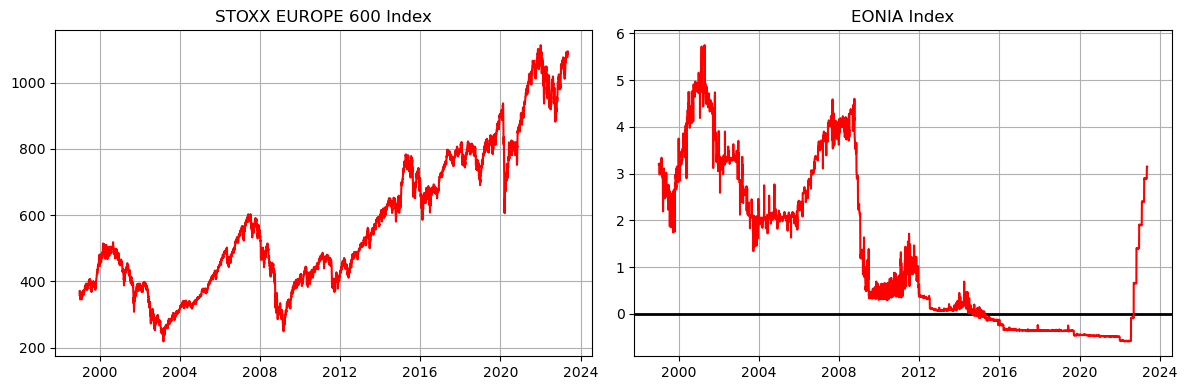

In [4]:
sxxr = pd.DataFrame(df["SXXR Index"])
eonia = pd.DataFrame(df["EONIA Index"])

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr, c="r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(eonia,c="r")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [5]:
pd.options.mode.chained_assignment = None

**ETUDES STATISTIQUES**
Semi-Déviation : La semi-déviation mesure la volatilité des rendements négatifs. 

Skewness : La skewness mesure l'asymétrie de la distribution des rendements. 

Kurtosis : La kurtosis mesure la "queue" de la distribution des rendements. Une kurtosis élevée indique une distribution avec des "queues" plus épaisses, ce qui signifie que le portefeuille a peut-être connu des rendements plus extrêmes, tant positifs que négatifs, par rapport à une distribution normale.

Historique VaR (5 %) : La Value at Risk (VaR) à un niveau de confiance de 5 % est une mesure de la perte potentielle. Une VaR historique de **M** % signifie qu'historiquement, le portefeuille avait une probabilité de 5 % de perdre au moins **M** % sur la période spécifiée.

VaR Cornish-Fisher (5 %) : Il s'agit d'une version ajustée de la VaR qui prend en compte la skewness et la kurtosis dans la distribution des rendements.

CVaR Historique (5 %) : La Conditional Value at Risk (CVaR) à un niveau de confiance de **M** % mesure la perte attendue au-delà de la VaR. Elle est de **M** %, ce qui signifie que si le portefeuille subissait une perte au-delà de la VaR, la perte moyenne serait de **M** %.

Rendement sur la VaR : Cette mesure est une évaluation du rendement ajusté en fonction du risque. 

Ratio de Sharpe : Le Ratio de Sharpe est une mesure du rendement ajusté en fonction du risque. Une valeur négative indique que le rendement ajusté en fonction du risque du portefeuille était très médiocre pendant la période spécifiée.

Ratio de Sortino : Le Ratio de Sortino est similaire au Ratio de Sharpe mais se concentre sur le risque à la baisse. Une valeur négative par exemple suggère que les rendements du portefeuille n'ont pas justifié son risque à la baisse.

Ratio Calmar : Le Ratio Calmar mesure le rendement ajusté en fonction du risque par rapport au retrait maximal. Une valeur négative par exemple indique que le rendement du portefeuille n'était pas suffisant pour compenser son retrait maximal.

Ratio Burke Modifié : Le Ratio Burke Modifié évalue le rendement ajusté en fonction du risque en mettant l'accent sur le risque à la baisse. Une valeur négative par exemple suggère une mauvaise performance ajustée en fonction du risque.

Drow Down : Le retrait maximal est la plus grande perte entre un sommet et un creux. Une valeur de **M** % indique la perte maximale subie par le portefeuille au cours de la période spécifiée.


In [6]:
#sxxxr returns
sxxr_rets = sxxr.pct_change().dropna()

#eonia mean value during all the period
eonia_rets = eonia/100
eonia_bt = np.float64(eonia.mean())

#risky asset as dataframe
risky_r = pd.DataFrame(sxxr_rets)


In [7]:
def box_pierce (r):
    """
    Computed Box-Pierce test
    """
    l_rows= ["sxxr rets"]
    returns = np.array(r)
    l_cols = ("Q","p(Q)")
    qtests = np.empty((1,2))         
    for i in range(1):
        qtest_loop = sm.stats.acorr_ljungbox(returns[:,i], lags=[1], boxpierce=True)
        qtests[i,:]= qtest_loop[2:]
    qtests = pd.DataFrame(data=qtests,columns=l_cols, index=l_rows)
    return qtests


def correlogram_plot (r):
    """
    Plot the Correlogram
    """
    returns = np.array(r)
    lags=np.arange(1,11,1)
    plot_acf(returns[:,0],lags=lags)
    return plt.show()


def annualize_rets(r, periods_per_year):
    """
    Annualize a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualize the volatility of a set of returns
    """
    return r.std()*(periods_per_year**0.5)


def drawdown (return_series: pd.Series):
    """
    Take a time series of asset returns and compute/return a DataFrame that contains:
    1. Wealth index
    2. Previous peaks
    3. Percent drawdowns
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks= wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdown
    })


def skewness(r):
    """
    Compute the skewness of the supplied Series/DataFrame
    Alternative to scipy.stats.skew()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Compute the kurtosis of the supplied Series/DataFrame
    Alternative to scipy.stats.kurtosis()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def var_historic (r, level=5):
    """
    Compute Value-at-Risk Historic
    """
    if isinstance(r,pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance (r,pd.Series):
        return -np.percentile(r,level)
    else: 
        raise TypeError("Expected r to be Series or DataFrame")
 

def var_gaussian(r, level=5, modified=False):
    """
    Return the Parametric Gaussian Value-at-Risk of a Series/DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # Compute the Z-score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # Modify the Z-score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Compute the Conditional Value-at-Risk of Series/DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
        
        
def semideviation(r,periods_per_year=252):
    """
    Compute the Annualized Semi-Deviation
    """
    neg_rets = r[r<0]
    return annualize_vol(r = neg_rets, periods_per_year=periods_per_year)    


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sharpe Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def sortino_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sortino Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    neg_rets = excess_ret[excess_ret<0]
    ann_vol = annualize_vol(neg_rets, periods_per_year)
    return ann_ex_ret/ann_vol


def calmar_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Calmar Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    max_dd = abs(drawdown(r).Drawdown.min())
    return ann_ex_ret/max_dd


def burke_ratio(r, riskfree_rate, periods_per_year, modified = False):
    """
    Compute the annualized Burke Ratio of a set of returns
    If "modified" is True, then the modified Burke Ratio is returned
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    sum_dwn = np.sqrt(np.sum((drawdown(r).Drawdown)**2))
    if modified == False:
        bk_ratio = ann_ex_ret/sum_dwn
    else:
        bk_ratio = ann_ex_ret/sum_dwn * np.sqrt(len(r))
    return bk_ratio

def summary_stats(r, riskfree_rate=np.float64(eonia_bt), periods_per_year=252):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    semidev = r.aggregate(semideviation, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_cr = r.aggregate(calmar_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_br = r.aggregate(burke_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year, modified = True)
    ann_sortr = r.aggregate(sortino_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    hist_var5 = r.aggregate(var_historic)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Volatility": round(ann_vol,4),
        "Semi-Deviation": round(semidev,4),
        "Skewness": round(skew,4),
        "Kurtosis": round(kurt,4),
        "Historic VaR (5%)": round(hist_var5,4),
        "Cornish-Fisher VaR (5%)": round(cf_var5,4),
        "Historic CVaR (5%)": round(hist_cvar5,4),
        "Sharpe Ratio": round(ann_sr,4),
        "Sortino Ratio": round(ann_sortr,4),
        "Calmar Ratio": round(ann_cr,4),
        "Modified Burke Ratio": round(ann_br,4),
        "Max Drawdown": round(dd,4)
    })


In [8]:
def run_hold(risky_r, safe_r = None, start = 100, risky_w=0.6, riskfree_rate = eonia_bt, periods_per_year = 252):
    """
    Compute the Buy-and-Hold portfolio where weights for risky/safe assets can vary according to the parameters selected in the function
    """
    # Set up the buy-and-hold 60/40 portfolio parameters
    dates = risky_r.index
    n_steps = len(dates)
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/periods_per_year
    safe_w = 1 - risky_w
    # Allocations to risky/safe assets according to the parameters selected in the function
    risky_alloc = (start * risky_w) * (1+risky_r).cumprod()
    safe_alloc = (start * safe_w) * (1+safe_r).cumprod()
    
    port_history = pd.DataFrame().reindex_like(risky_r)
    port_history = risky_alloc + safe_alloc
    
    vocabulary_result = {
        "Buy-and-Hold": port_history, 
        "Risky Allocation": risky_alloc,
        "Safe Allocation": safe_alloc,
        "Risky Weight": risky_w
    }
    return vocabulary_result


In [9]:
#Choose your period
sxxr_rets = sxxr_rets['2016-01-01':'2020-12-31']
eonia_rets = eonia['2016-01-01':'2020-12-31']

#eonia mean value during all the period
eonia_m = eonia_rets/100
eonia_bt = np.float64(eonia_rets.mean())

#risky asset as dataframe
risky_r = pd.DataFrame(sxxr_rets)


In [10]:
eonia_rets

,EONIA Index
Dates,
2016-01-01,-0.127
2016-01-04,-0.241
2016-01-05,-0.251
2016-01-06,-0.253
2016-01-07,-0.233
...,...
2020-12-25,-0.470
2020-12-28,-0.468
2020-12-29,-0.472


In [11]:
risky_r 

,SXXR Index
Dates,
2016-01-01,0.000000
2016-01-04,-0.024993
2016-01-05,0.006212
2016-01-06,-0.012622
2016-01-07,-0.022067
...,...
2020-12-25,0.000000
2020-12-28,0.006565
2020-12-29,0.007615


In [12]:
Port_60_40 = run_hold(sxxr_rets)
print(Port_60_40)

{'Buy-and-Hold':               SXXR Index
Dates                   
2016-01-01    100.211300
2016-01-04     98.924141
2016-01-05     99.501083
2016-01-06     98.972771
2016-01-07     97.906017
...                  ...
2020-12-25  37997.318553
2020-12-28  38198.134366
2020-12-29  38400.090113
2020-12-30  38602.287554
2020-12-31  38805.578267

[1305 rows x 1 columns], 'Risky Allocation':             SXXR Index
Dates                 
2016-01-01   60.000000
2016-01-04   58.500426
2016-01-05   58.863830
2016-01-06   58.120851
2016-01-07   56.838298
...                ...
2020-12-25   74.283404
2020-12-28   74.771064
2020-12-29   75.340426
2020-12-30   75.087660
2020-12-31   74.858723

[1305 rows x 1 columns], 'Safe Allocation':               SXXR Index
Dates                   
2016-01-01     40.211300
2016-01-04     40.423716
2016-01-05     40.637254
2016-01-06     40.851920
2016-01-07     41.067720
...                  ...
2020-12-25  37923.035149
2020-12-28  38123.363302
2020-12-29  38324.

In [13]:
# Get the terminal value for 60/40 Portfolio
term_wealth_bh = np.float64(Port_60_40["Buy-and-Hold"].iloc[-1])
round(term_wealth_bh,2)

38805.58

In [14]:
# Compute returns for 60/40 Portfolio
hold_rets = Port_60_40["Buy-and-Hold"].pct_change().dropna()
hold_rets.columns = ["60/40 Portfolio Returns"]

In [15]:
summary_stats(hold_rets)

,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
60/40 Portfolio Returns,0.0441,0.0882,-3.1987,32.5435,-0.0009,0.0003,0.004,8.1204,4.7506,8.4495,97.5788,-0.0424


In [16]:
def interest(df:pd.DataFrame=sxxr, initial:float = 100,year: Union[int,str] = 2000, horizon:int=5, 
             y0:Union[int,str] = 2000,alldata:bool = True)->pd.DataFrame:
    """
    parameters:
        df:The index SXXR
        initial: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """
    if type(y0)==int:
        tabn = df[str(y0-1):str(y0-1)]
        tabn = pd.DataFrame(tabn.iloc[-1]).T
        
    if type(y0)==str:
        y = int(y0[0:4])
        tab = df[y0:str(y+horizon)]
    elif type(y0)==int:
        tab = df[str(y0):str(y0+horizon)] 
        tab = pd.concat([tabn,tab])
    
    n = len(tab)
    S = [x for x in tab["SXXR Index"]]
    rate = []
    S0 = S[0]
    compteur = 0
    for t in S:
        if compteur==0:
            rendement = round((S[compteur]/S0 -1)*100,3)
        else:
            rendement = round((S[compteur]/S[compteur-1] -1)*100,3)
        rate.append(rendement)
        compteur += 1
    tab["Return"] = rate 
    tab = tab.drop("SXXR Index", axis = 1)
    invest = []
    count = 0
    for t in rate:
        if count == 0:
            inv = initial * (1 + t/100)
        else:
            inv = invest[-1] * (1 + t/100)
        count += 1
        invest.append(inv)
    tab["SXXR Index"] = invest
    tab = tab.drop("Return", axis = 1)
    if alldata:
        obj = tab
    else:
        obj = particularyear(tab,year)
    return obj

def monetarize(df:np.ndarray, nav:float, year:Union[int,str] =2000, 
               horizon:int=0,y0:Union[int,str]=2000, alldata:bool=True)->pd.DataFrame:
    """
    parameters:
        df:The index EONIA
        nav: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """

    
    # Années précédente, à prendre le dernier jour
    if type(y0)==int:
        tab_prec = df[str(y0-1):str(y0-1)]
        tab_prec["Loan"] = 100
        tab_prec = pd.DataFrame(tab_prec.iloc[-1]).T
        # Années en cours sur un horizon donné
        tab_suiv = df[str(y0):str(y0+horizon)]
        tab_suiv["Loan"] = 100
        tab = pd.concat([tab_prec, tab_suiv])
    if type(y0)==str:
        y = int(y0[0:4])
        tab = df[y0:str(y+horizon)]
        tab["Loan"]=100
    
    rate = [x for x in tab.iloc[:,0]]
    table = np.zeros((len(rate)+1,1))
    table[0] = nav
    compteur = 0
    for elem in rate:
        compteur+=1
        table[compteur] = np.round(table[compteur-1] * (1 + elem/(365*100)),5)
    tab["Loan"] = np.round(table[0:-1],3)
    tab = tab.drop("EONIA Index", axis = 1)
    # Year Y
    if type(y0)==int:
        tabl = tab[str(y0):str(y0+horizon)]
        # Year Y-1
        yearn = y0-1
        tabn = tab[str(yearn):str(yearn)]
        yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T
        # Concatenate    
        tabulate = pd.concat([yearn_last_day,tabl])
    elif type(y0)==str:
        tabl = tab[y0:str(y+horizon)]
        tabulate = tabl
    
    tabulate["EONIA Index"] = tabulate
    tabulate = tabulate.drop("Loan", axis = 1)
    if alldata:
        obj = tabulate
    else:
        obj = particularyear(tabulate,year)
    
    return obj

def particularyear(df:pd.DataFrame,year):
    tab = df
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T

    # Year Y
    tabl = tab[str(year):str(year)]  
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    return tabulate 

def concat(df1:pd.DataFrame, df2:pd.DataFrame):
    if all(df1.index == df2.index):
        tab = pd.concat([df1,df2],axis =1 )
    else:
        print("Please, be sure both DataFrame have the same index")
    return tab

def VL(df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia,initial:float=100, weight:float=0.8, year:int=2000, horizon:int=5,y0:int=2000, alldata:bool=True):
    initial_risk = weight * initial
    initial_norisk = (1-weight) * initial
    risk = interest(df1,initial_risk, year,horizon,y0,alldata)
    norisk = monetarize(df2, initial_norisk, year,horizon,y0,alldata)
    tab = concat(risk,norisk)
    tab["VL"] = tab["SXXR Index"] + tab["EONIA Index"]
    tab = pd.DataFrame(tab["VL"])
    return tab

def get_list_protected(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab

# Exemple - Représentations Graphiques des indices

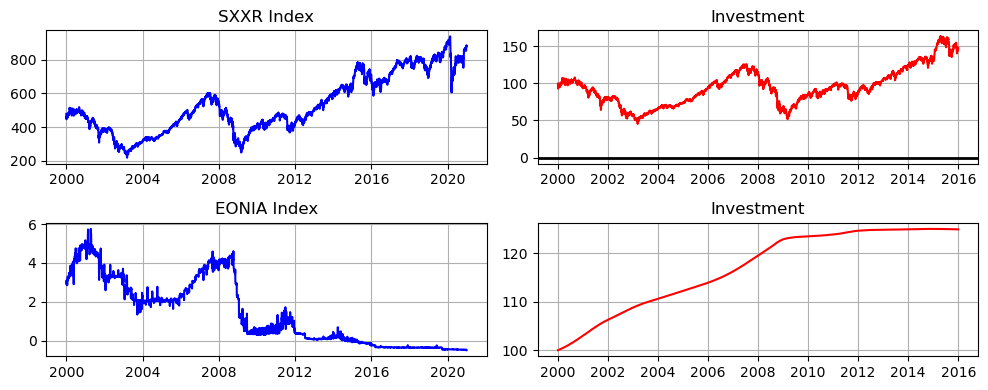

In [17]:
investment = interest(sxxr,100,2001,15,2000)
monnaie = monetarize(eonia, 100, 2001, 15,2000)

# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr["2000":"2020"], c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(investment["2000":"2020"],c="r")
ax2.set_title('Investment')
ax2.grid(True)

# Tracé des graphiques à gauche
ax3.plot(eonia["2000":"2020"], c="b")
ax3.set_title('EONIA Index')
ax3.grid(True)

ax4.plot(monnaie["2000":"2020"],c="r")
ax4.set_title('Investment')
ax4.grid(True)



# Affichage de la figure
plt.tight_layout()
plt.show()


In [18]:
def volatility(df:pd.DataFrame,msg:bool=False):
    tab = df.copy()
    S = [x for x in tab.iloc[:,0]]
    rendement = []
    for i in range(len(S)):
        if i==0:
            r = 0
        else:
            rt = S[i]
            rtt = S[i-1]
            r = np.log(rt/rtt)
        rendement.append(r)
    m = np.mean(rendement)
    if abs(m)<0.01:
        m = 0
    else:
        m = m
    
    rendement = np.array(rendement).reshape(-1,1)
    moyenne = m*np.ones((len(rendement),1))
    rend = rendement - moyenne
    
    sig2 = float(1/(len(rendement)-1) * (sum((rend)**2)))
    sig = np.sqrt(sig2)
    annualized = sig * np.sqrt(252)
    
    if msg == True:
        print(f"La volatilité de la série s'élève à {round(annualized*100,3)} % ")
    else:
        pass
    
    return annualized

## CPPI - Un test sur les planchers, sans protection

In [19]:
class CPPI:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
        
    def liquidative(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):
        df1 = self.df1
        df2 = self.df2
        vl = VL(df1,df2,initial, weight, year, horizon, y0, alldata)
        protec = get_list_protected(vl, year, plancher, horizon)
        
        return protec
    
    def unified(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):

        # Year Y
        df_0 = self.liquidative(initial, weight, plancher, year,horizon, y0,False)
        df_0 = df_0.drop(df_0.index[-1])
        # Year Y+1
        df_1 = self.liquidative(initial, weight, plancher, year+1,horizon, y0,False)
        df_1 = df_1.drop(df_1.index[-1])
        # Year Y+2
        df_2 = self.liquidative(initial, weight, plancher, year+2,horizon, y0,False)
        df_2 = df_2.drop(df_2.index[-1])
        # Year Y+3
        df_3 = self.liquidative(initial, weight, plancher, year+3,horizon, y0,False)
        df_3 = df_3.drop(df_3.index[-1])
        # Year Y+4 (Final)
        df_4 = self.liquidative(initial, weight, plancher, year+4,horizon, y0,False)
        
        # Concat :
        df = pd.concat([df_0,df_1,df_2,df_3,df_4],axis=0)
        return df

<AxesSubplot:>

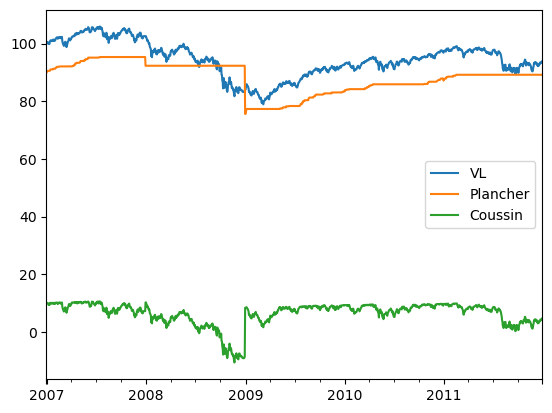

In [20]:
a = CPPI()
b = a.liquidative(100,0.45,0.9,2007,5,2007,False)
c = a.unified(100,0.45,0.9,2007,5,2007,False)
c.plot()

# CPPI - Avec protection

In [21]:
def reajust_date(df:pd.DataFrame)->str:
    tab = df
    n = len(tab)
    coussin = pd.DataFrame(tab["Coussin"])
    coussin["Rang"] = range(n)
    couss = [round(x,4) for x in coussin["Coussin"]]
    
    negcouss = []
    date = []
    count = 0
    if min(couss) <= 0:
        for c in coussin["Coussin"]:
            if c <= 0:
                negcouss.append(count)
                dateJ = coussin.iloc[count:count+1].index[0]
                date.append(dateJ)
            count += 1
    else:
        count = len(coussin)-1
        negcouss.append(count) #The last index
        dateJ = coussin.iloc[count:count+1].index[0]
        date.append(dateJ)
        
    location_index = negcouss[0]
    location_date = date[0]
    
    return location_date, location_index

investment = interest(sxxr,100,2001,20,2000)
monnaie = monetarize(eonia, 100, 2001, 20,2000)

def reajust(df:pd.DataFrame, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia, year:int=2000, y0:int=2000, horizon:int=5,initial:float =100, weight:float = 0.8,alldata:bool=True):
    tab = df
    risk_invest = initial * weight
    norisk_invest = initial * (1-weight)
    investment = interest(df1,risk_invest,year,horizon,y0,alldata)
    monnaie = monetarize(df2, norisk_invest,year,horizon,y0,alldata)
    indexes = concat(investment,monnaie)
    tabulate = concat(tab, indexes)
    date_couss_negative = reajust_date(df)[0]
    data= pd.DataFrame(tabulate.loc[date_couss_negative:str(year)])
    eonia = df2.loc[date_couss_negative:str(year)]
    allocation = data[["SXXR Index", "EONIA Index"]]
    allocation["EONIA"] = eonia
    allocation["EONIA Index"] = allocation["SXXR Index"] + allocation["EONIA Index"]
    allocation["SXXR Index"] = 0
    rate = [x for x in allocation["EONIA"]]
    val = []
    nb = len(allocation)
    count = 0
    index_couss_negative = reajust_date(df)[1]
    if index_couss_negative != len(df)-1:
        for r in rate:
            if count == 0:
                value = allocation.iloc[count,1]
            else:
                value = val[count-1] * (1+r/(365*100))
            count += 1 
            val.append(value)
        allocation['VL'] = val
        before = pd.DataFrame(tabulate["VL"].iloc[0:index_couss_negative,])
        after = pd.DataFrame(allocation["VL"])
        result = pd.concat([before,after],axis=0)
    else:
        result = pd.DataFrame(tabulate["VL"])
    return result

def everydata(df:pd.DataFrame,df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia,weight_risk:float=0.6, weight_norisk:float =0.4):
    table = pd.DataFrame(df["VL"].copy())
    year_begin = int(str(table.index[1])[0:4])
    year_end = int(str(table.index[-1])[0:4])
    initial = 100
    begin_weight_risk = weight_risk * initial
    begin_weight_norisk = weight_norisk * initial
    df1 = df1.copy()
    df2 = df2.copy()
    nb_year = year_end - year_begin
    risk = interest(df1, begin_weight_risk,year_begin,nb_year,year_begin,True)
    norisk = monetarize(df2,begin_weight_norisk,year_begin,nb_year,year_begin,True)
    alldata = pd.concat([table,risk,norisk],axis = 1)
    
    return alldata



In [22]:
class FinalCPPI:
    def __init__(self, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia):
        self.df1 = df1
        self.df2 = df2
        
        self.fees = 0.01
        self.all_fees = []
        
    def finalprotection(self,initial = 100, weight=0.8, year=2000, horizon=5,y0=2000, alldata=False,plancher=0.9,h=5):
        df1 = self.df1
        df2 = self.df2
        
        liste = []
        lastval = initial * (1-self.fees)
        self.all_fees.append(initial*self.fees)
        for i in range(h):
            val = VL(df1,df2,lastval,weight,year+i,horizon,y0+i,alldata)
            protect_priori = get_list_protected(val, year+i,plancher,0)
            ajustement = reajust(protect_priori,df1,df2,year+i,y0+i,horizon,lastval,weight,alldata)
            protect_posteriori = get_list_protected(ajustement, year+i, plancher, 0)
            if i != max(range(5)):
                protect_posteriori = protect_posteriori.drop(protect_posteriori.index[-1])
            lastval = protect_posteriori.iloc[-1,0] * (1-self.fees)
            self.all_fees.append(protect_posteriori.iloc[-1,0] * self.fees)
            liste.append(protect_posteriori)
        
        df = pd.concat(liste,axis=0)
        return df

class Statistic:
    def __init__(self, df:pd.DataFrame, df1:pd.DataFrame=sxxr,df2:pd.DataFrame=eonia):
        self.df = df.copy()
        self.df1 = df1.copy()
        self.df2 = df2.copy()
        if "VL" in self.df:
            pass
        else:
            print("ERROR ! Le tableau VL n'existe pas")
        self.tab = pd.DataFrame(self.df["VL"])
        
        
    def moyenne(self, msg:bool=False):
        moy = float(np.mean(self.tab))
        if msg==True:
            print(f"La valeur liquidative moyenne s'élève à : {moy}")
        else:
            pass
        return moy
    
    def annualized_volatility(self,msg:bool = False):
        vol = float(volatility(self.tab,False))
        if msg == True:
            print(f"La volatilité de la série s'élève à {round(vol*100,3)} % ")
        else:
            pass
        return vol
    
    def ratiosharpe(self, msg:bool=False):
        tab =  pd.DataFrame(self.df["VL"])
        rdmt_ann = self.rendement_annualise(False)
        
        eon = [x/100 for x in self.df2.iloc[:,0]]
        eon_mean = np.mean(eon)
        
        vol = volatility(tab)
        
        sharpe = (rdmt_ann-eon_mean)/vol
        
        if msg == True:
            print(f"Le ratio de sharpe est à hauteur de {round(sharpe,2)}")
        
        return sharpe
    
    def drawdown(self, msg:bool=False,comparaison:bool=False):
        tab = pd.DataFrame(self.df["VL"]).copy()
        tab["DrawDown"] = 0
        n = len(tab)
        vl = [x for x in tab.iloc[:,0]]
        DD = []
        for i in range(len(vl)):
            if i < len(vl)-1:
                current = vl[i]
                draw = (min(vl[i+1:])/current)-1
                DD.append(draw)
        maxdraw = min(DD)

        themax_index = DD.index(maxdraw)
        
        
        if msg==True:
            print(f"Le max drawdown du Fonds est de : {round(maxdraw*100,2)}%")
            pass
        else:
            pass
        
        if comparaison==True:
            debut = str(tab.index[1])[0:4]
            fin = str(tab.index[-1])[0:4]
            tab1 = self.df1[debut:fin].copy()
            ind = [x for x in tab1.iloc[:,0]]
            DDsxxr = []
            for i in range(len(tab1)):
                if i < len(tab1)-1:
                    currentsxxr = ind[i]
                    drawsxxr = (min(ind[i+1:])/currentsxxr)-1
                    DDsxxr.append(drawsxxr)
            maxdrawsxxr = min(DDsxxr)
            print(f"Le max drawdown de l'indice SXXR est de : {round(maxdrawsxxr*100,2)}%")
        
        return pd.DataFrame(tab.iloc[themax_index:,0])
    
    def skewness(self,msg:bool = False):
        tab = pd.DataFrame(self.df["VL"])
        mean = self.moyenne(False)
        vl = [x for x in tab.iloc[:,0]]
        std = np.std(vl)
        tab["For skew"] = ((tab["VL"]-mean)/std)**3
        allskew = [x for x in tab.iloc[:,1]]
        
        skew = np.mean(allskew)
        
        if msg==True:
            print(f"Le skewness de la série est de : {round(skew,2)}")
        else:
            pass
        
        return skew
    
    def rendement_annualise(self, msg:bool=False):
        tab = pd.DataFrame(self.df["VL"])
        initiale = float(tab.iloc[0,0]) 
        finale = float(tab.iloc[-1,0])
        year_initiale = int(str(tab.iloc[0:,0].index[0])[0:4])
        year_finale = int(str(tab.iloc[0:,0].index[-1])[0:4])
        nb_year = year_finale-year_initiale
        rendement_ann = (finale/initiale)**(1/nb_year) -1
        
        if msg == True:
            print(f"Sur une période de 5 ans, le Fonds a généré un rendement annualisé de {round(rendement_ann*100,2)}%")
        
        return rendement_ann
    
    def allstat(self)->None:
        moy = self.moyenne(True)
        annvol = self.annualized_volatility(True)
        sharpe = self.ratiosharpe(True)
        draw = self.drawdown(True,True)
        skew = self.skewness(True)
        annrend = self.rendement_annualise(True)
        return None


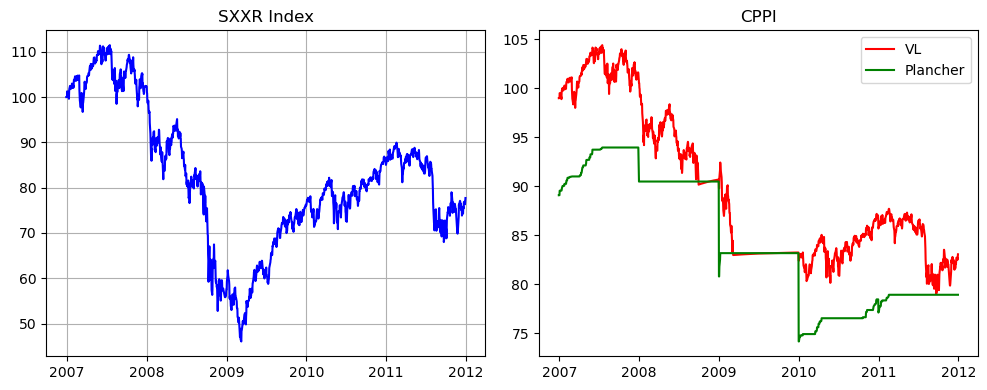

In [23]:
cppi2007 = FinalCPPI()
protection2007 = cppi2007.finalprotection(100,0.4,2007,10,2007,False,0.9,5)
investment2007 = interest(sxxr,100,2007,4,2007)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2007, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2007["VL"], c="r",label="VL")
ax2.plot(protection2007["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
allfees = cppi2007.all_fees
allfees

[1.0,
 1.0156295149829242,
 0.9069814723303223,
 0.832600239835654,
 0.8657107623783968,
 0.8307543816745826]

In [25]:
# Volatilité 

df2007 = pd.DataFrame(protection2007["VL"])
vol2007 = volatility(df2007)
volsxxr2007 = volatility(sxxr["2007":"2011"])

# Crise 2008

sxxr2008 = sxxr["2008"]
sxxrjan2008 = sxxr2008.iloc[0,0]
sxxrdec2008 = sxxr2008.iloc[-1,0]
print(f"Sur l'année 2008, l'indice a baissé de {round(abs(sxxrdec2008/sxxrjan2008 -1)*100,3)}%, \
passant de {round(sxxrjan2008,2)}€ à {round(sxxrdec2008,2)}€ ")

Sur l'année 2008, l'indice a baissé de 43.769%, passant de 553.54€ à 311.26€ 


In [26]:
# Période 2007-2012
stat2007  = Statistic(protection2007)
vol2007 = volatility(sxxr["2007":"2011"])
data2007 = stat2007.allstat()

La valeur liquidative moyenne s'élève à : 89.55054277169488
La volatilité de la série s'élève à 7.175 % 
Le ratio de sharpe est à hauteur de -0.67
Le max drawdown du Fonds est de : -24.27%
Le max drawdown de l'indice SXXR est de : -58.69%
Le skewness de la série est de : 0.64
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de -3.45%


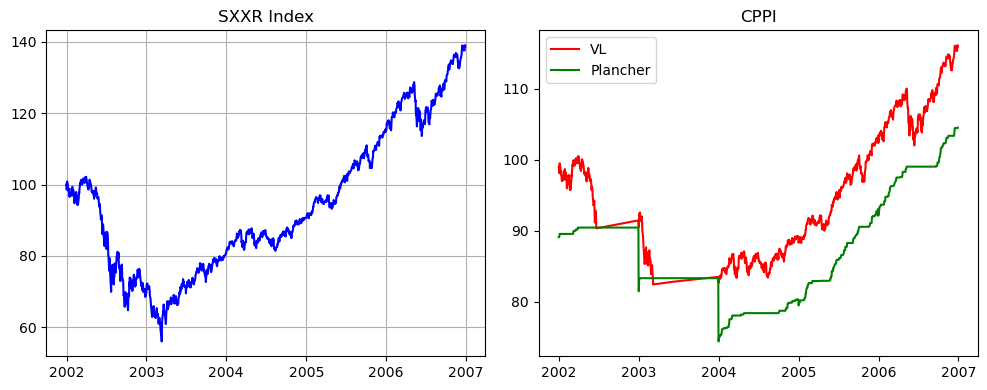

In [27]:
cppi2002 = FinalCPPI()
protection2002 = cppi2002.finalprotection(100,0.6,2002,10,2002,False,0.9,5)
investment2002 = interest(sxxr,100,2002,4,2002)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2002, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2002["VL"], c="r",label="VL")
ax2.plot(protection2002["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Période 2002-2007
stat2002  = Statistic(protection2002)
data2002 = stat2002.allstat()

La valeur liquidative moyenne s'élève à : 93.46839926781699
La volatilité de la série s'élève à 6.659 % 
Le ratio de sharpe est à hauteur de 0.28
Le max drawdown du Fonds est de : -17.97%
Le max drawdown de l'indice SXXR est de : -45.18%
Le skewness de la série est de : 0.66
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de 3.21%


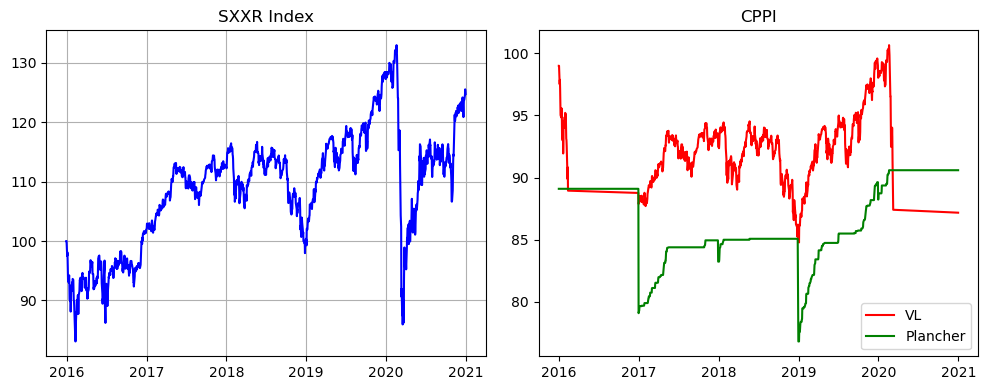

In [29]:
cppi2016 = FinalCPPI()
protection2016 = cppi2016.finalprotection(100,0.6,2016,10,2016,False,0.9,5)
investment2016 = interest(sxxr,100,2016,4,2016)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2016, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2016["VL"], c="r",label="VL")
ax2.plot(protection2016["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Période 2016-2021
stat2016 = Statistic(protection2016)
data2016 = stat2016.allstat()

La valeur liquidative moyenne s'élève à : 91.04163876683828
La volatilité de la série s'élève à 6.527 % 
Le ratio de sharpe est à hauteur de -0.59
Le max drawdown du Fonds est de : -14.36%
Le max drawdown de l'indice SXXR est de : -35.36%
Le skewness de la série est de : 0.65
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de -2.51%


In [31]:
pro2016 = everydata(protection2016,sxxr,eonia,0.6,0.4)
pro2007 = everydata(protection2007,sxxr,eonia,0.6,0.4)
pro2002 = everydata(protection2002,sxxr,eonia,0.6,0.4)
pro2007

,VL,SXXR Index,EONIA Index
2006-12-29,99.000000,60.000000,40.000
2007-01-01,99.006000,60.000000,40.004
2007-01-02,99.514524,60.761400,40.008
2007-01-03,99.519722,60.760185,40.012
2007-01-04,99.408625,60.582765,40.016
...,...,...,...
2011-12-26,82.725831,46.113502,42.893
2011-12-27,82.733647,46.123647,42.894
2011-12-28,82.516713,45.800781,42.894
2011-12-29,82.806986,46.231308,42.895


<AxesSubplot:>

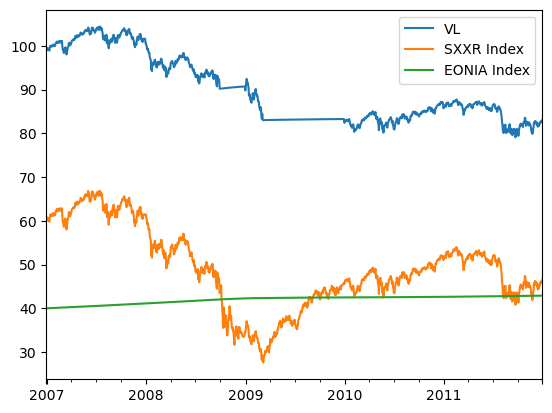

In [32]:
pro2007.plot()

In [33]:
cppi2016 = FinalCPPI()
protection2016 = cppi2016.finalprotection(100,0.6,2016,10,2016,False,0.9,5)
investment2016 = interest(sxxr,100,2016,4,2016)

In [34]:
cppi_2007_2012 = FinalCPPI()
protection_2007_2012 = cppi_2007_2012.finalprotection(100,0.4,2007,10,2007,False,0.9,5)
VL_2007_2012 = protection_2007_2012["VL"].pct_change().reset_index(drop = "TRUE")
eonia = pd.DataFrame(df["EONIA Index"])/100
VL_2007_2012 =pd.DataFrame({'2007_2012_CPPI': VL_2007_2012}).dropna()

riskfree_2007_2012 = eonia['2007-01-01':'2012-01-31']
riskfree_2007_2012_mean = np.float64(riskfree_2007_2012.mean())
riskfree_2007_2012_mean

0.01926278824415976

In [35]:
summary_stats(VL_2007_2012,riskfree_2007_2012_mean)

,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
2007_2012_CPPI,0.0717,0.057,-0.044,7.0661,0.0075,0.0072,0.0113,-0.719,-0.9308,-0.2125,-0.3237,-0.2427


In [36]:
cppi_2016_2020 = FinalCPPI()
protection_2016_2020 = cppi_2016_2020.finalprotection(100,0.4,2016,10,2016,False,0.9,5)
VL_2016_2020 = protection_2016_2020["VL"].pct_change().reset_index(drop = "TRUE")
eonia = pd.DataFrame(df["EONIA Index"])/100
VL_2016_2020 =pd.DataFrame({'2016_2020_CPPI': VL_2016_2020 }).dropna()

riskfree_2016_2020 = eonia['2016-01-01':'2020-12-31']
riskfree_2016_2020_mean = np.float64(riskfree_2016_2020.mean())
riskfree_2016_2020_mean

-0.003781908045977004

In [37]:
summary_stats(VL_2016_2020,riskfree_2016_2020_mean)

,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
2016_2020_CPPI,0.0554,0.051,-2.2701,23.6521,0.0055,0.0062,0.0093,-0.1662,-0.1637,-0.0691,-0.1604,-0.1332
